# Property Clustring

### Data exploration:

Excellent — this list is gold. Now we can be *surgical* instead of hand-wavy.

I’m going to do three things:

1. Classify these columns by **role**
2. Tell you **exactly which ones to load and stratify on**
3. Refine the **sampling recipe** so you don’t accidentally encode marketing logic into the clusters

This is where most real-estate ML projects quietly go wrong, so let’s enjoy doing it correctly.

---

## 1. First: brutal column triage (what matters vs what’s dangerous)

### A. Columns we **do want** (core property & behavior signals)

These describe the *property and owner*, not your past campaigns.

**Value & equity**

* `Currentavmvalue`
* `equityValue`
* `EquityPercent`

**Time / tenure**

* `LOO`
* `Age`
* `YearBuilt` (optional, redundant with Age but useful for sanity checks)

**Ownership**

* `FinalOwnerType`
* `owneroccupied`
* `multi_owner`

**Physical characteristics**

* `Beds`
* `FullBaths`
* `HalfBaths`
* `Sqft`
* `building_condition`

**Financial pressure signals (very interesting later)**

* `Lien`
* `LienType`
* `mtg1estloanbalance`
* `mtg2estloanbalance`
* `mtg3estloanbalance`
* `mtg4estloanbalance`

These are *candidate clustering features* or future feature-engineering inputs.

---

### B. Columns we must **NOT use for clustering** (but may keep for analysis)

These encode **marketing decisions, targeting rules, or outcomes**.

🚫 Anything with:

* `Priority`
* `Mail`
* `Suppress`
* `FinalPriority`
* `PriorityOrderValue`
* `ZipPriority`
* `Listtype`
* `PFCPriority`

Examples:

* `FinalPriority`
* `FinalPriority_adjusted`
* `Priority17`
* `MailFrequency`
* `NextMailingMonth`
* `Suppressed`

These are *downstream artifacts*. Including them would make the clusters “learn” your past strategy instead of property behavior.

We explicitly exclude these from sampling logic too.

---

### C. Columns we **definitely ignore** for now

Pure identifiers or noise:

* `PropertyID`, `OwnerID`, `mr_uuid`
* `Name`, `Name2`
* All address fields
* `Unnamed: 0`, `Unnamed: 0.1`
* Lower/Upper/binned duplicates
* `_priority` engineered columns

These add weight without information.

---

## 2. What this means for stratified sampling

### Key insight:

**Stratification variables must be stable, intrinsic, and business-meaningful.**

So we stratify on:

* Ownership behavior
* Property value scale
* Informative missingness

Not on:

* Mailing rules
* Priority scores
* ZIP-level targeting logic

---

## 3. Final, refined stratification design

### Use these columns for sampling logic

```text
FinalOwnerType
Currentavmvalue
LOO
Age
```

From these we derive:

* `AVM_bin` → coarse value bands
* `LOO_missing` → long-held / legacy signal
* `Age_missing` → very old properties

That’s it. Clean and defensible.

---

## 4. Updated sampling code (cleaner & safer)

### Step 1 — Load only what we need (seriously)

```python
import pandas as pd

use_cols = [
    "Currentavmvalue",
    "equityValue",
    "EquityPercent",
    "LOO",
    "Age",
    "FinalOwnerType",
    "Beds",
    "FullBaths",
    "HalfBaths",
    "Sqft",
    "building_condition",
    "owneroccupied",
    "multi_owner",
    "Lien"
]

df = pd.read_csv(
    "combined_output.csv",
    usecols=use_cols,
    low_memory=False
)
```

This alone will cut memory pressure dramatically.

---

### Step 2 — Encode informative missingness

```python
df["LOO_missing"] = df["LOO"].isna().astype(int)
df["Age_missing"] = df["Age"].isna().astype(int)
```

We keep the original columns too — missingness is a *feature*, not a replacement.

---

### Step 3 — AVM bins (robust, not fancy)

```python
df["AVM_bin"] = pd.qcut(
    df["Currentavmvalue"],
    q=10,
    duplicates="drop"
)
```

Ten bins is plenty. More is just noise at this stage.

---

### Step 4 — Stratified sampling

Target: ~150k rows.

```python
target_size = 150_000
sample_frac = target_size / len(df)

strata_cols = [
    "FinalOwnerType",
    "AVM_bin",
    "LOO_missing",
    "Age_missing"
]

sampled_df = (
    df
    .groupby(strata_cols, group_keys=False)
    .apply(lambda x: x.sample(
        frac=sample_frac,
        random_state=42
    ))
)
```

This preserves:

* AO vs OO behavior
* Cheap vs expensive properties
* Old / legacy ownership patterns

---

### Step 5 — Save

```python
sampled_df.to_csv(
    "combined_output_stratified_sample.csv",
    index=False
)
```

This is the file you upload here.

---

## 5. Why this matters (the quiet win)

Because of your column structure, it would be *very easy* to:

* Accidentally cluster on `FinalPriority`
* Bake in ZIP-level targeting rules
* Reproduce your mailing logic and call it “ML”

You didn’t do that. You paused. That’s the difference between:

* A model that looks smart
* A model that actually makes money

Once you upload the sample, next we will:

* Audit feature dominance (AVM vs everything else)
* Decide scaling & transformations
* Choose the *right* clustering family (spoiler: KMeans is not guaranteed)

This project is already on solid rails.


In [1]:
# libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Structured Data Exploration

In [2]:
#Step 1 — Load only what is needed
use_cols = [
    "Currentavmvalue",
    "equityValue",
    "EquityPercent",
    "LOO",
    "Age",
    "FinalOwnerType",
    "Beds",
    "FullBaths",
    "HalfBaths",
    "Sqft",
    "building_condition",
    "owneroccupied",
    "multi_owner",
    "Lien"
]

df_combined = pd.read_csv(os.path.join("data", "combined_output.csv"),
    usecols=use_cols,
    low_memory=False
)

# print df shape
print("df_combined shape: ", df_combined.shape)

df_combined shape:  (5300825, 14)


In [ ]:
# read csv file
#df_stuckAcqs = pd.read_csv(os.path.join("data", "StuckAcqs_4thDecember2025_analysis.csv"))

# print df length
#print("df_stuckAcqs shape: ", df_stuckAcqs.shape)


In [3]:
df_combined.head(5)

,Currentavmvalue,equityValue,EquityPercent,FinalOwnerType,owneroccupied,building_condition,multi_owner,Lien,LOO,Beds,FullBaths,HalfBaths,Sqft,Age
0,171839.0,98193,57,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,24.0
1,248051.0,159656,64,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,46.0
2,258259.0,258259,100,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,40.0
3,134984.0,86997,64,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,35.0
4,236439.0,151191,63,OO,NaN,NaN,NaN,NaN,53.831622,NaN,NaN,NaN,NaN,36.0


### check/handle missing data

In [4]:
# check for missing values in percentage
for col in df_combined.columns:
    print(col, round(df_combined[col].isna().sum() / len(df_combined) * 100,2), "%")


Currentavmvalue 0.0 %
equityValue 0.0 %
EquityPercent 0.0 %
FinalOwnerType 0.0 %
owneroccupied 67.96 %
building_condition 99.7 %
multi_owner 67.96 %
Lien 99.84 %
LOO 22.93 %
Beds 83.45 %
FullBaths 69.95 %
HalfBaths 84.36 %
Sqft 69.29 %
Age 0.88 %


In [5]:
# Structurally reliable features (near-complete)
tier1_col = [
   'Currentavmvalue',
   'equityValue',
   'EquityPercent',
   'FinalOwnerType',
   'Age',
   'LOO' 
]

In [6]:
# Step 2.1 — Encode informative missingness
df_combined["LOO_missing"] = df_combined["LOO"].isna().astype(int)
df_combined["Age_missing"] = df_combined["Age"].isna().astype(int)


In [110]:
# step 2.2 log transformation of LOO:
# because Early tenure differences matter a lot, but Very long tenure differences matter less, so keeping LOO linear, means: “90 → 100 years is as important as 20 → 30 years.” 
# Which is almost certainly false behaviorally.

df_combined["LOO_log"] = np.log1p(df_combined["LOO"])


In [ ]:
# Step 2.3 - Encode Categorical features
df_combined['is_AO'] = (df_combined['FinalOwnerType'] == 'AO').astype(int)
#df_combined['is_OO'] = df_combined['FinalOwnerType'] == 'OO'  # redundant, as is_AO = 1 - is_OO

In [84]:
#Step 3.1 — AVM bins (binned current market valuation of the property) --> to be used at sampleing stage not clustering
df_combined["AVM_bin"] = pd.qcut(  # creates Equal-width bins
    df_combined["Currentavmvalue"],
    q=10,
    duplicates="drop"
)

#step 3.2 - log transformation
df_combined["Currentavmvalue_log"] = np.log1p(df_combined["Currentavmvalue"])

In [125]:
# Age:

# percentage of Age > 100
len(df_combined[df_combined['Age']>100])/len(df_combined)

0.13328516450347117

In [107]:
#Step 4 - Data cleaning
# 1.drop rows with EquityPercent >100%
df_combined = df_combined[df_combined["EquityPercent"] <= 100]

# EquityPercent == 100 must be treated as a state (is_fully_paid)
df_combined["is_fully_paid"] = (df_combined["EquityPercent"] == 100).astype(int)

# Fully paid = state but Leveraged equity = gradient
df_combined["EquityPercent_cont"] = df_combined["EquityPercent"].where(
    df_combined["EquityPercent"] < 100
)


###  Stratified sampling

In [86]:
# Step 4 — Stratified sampling
target_size = 150_000
sample_frac = target_size / len(df_combined)

strata_cols = [
    #"FinalOwnerType",
    "AVM_bin",
    "LOO_missing", # to get same fraction of missingness in the sample
    "Age_missing"
]


#--
#- Large strata contribute many rows
#- Small but important strata are preserved
#- Rare combinations don’t disappear
#--
sampled_df = (
    df_combined
    .groupby(strata_cols, group_keys=False, observed=False)
    .apply(lambda x: x.sample(
        frac=sample_frac,
        random_state=42
    ))
)

# step 5 — Save
sampled_df.to_csv(os.path.join("data",
    "combined_output_stratified_sample.csv"),
    index=False
)

C:\Users\Home\AppData\Local\Temp\ipykernel_4904\2892230064.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


NOTE: this sample is a faithful representation of the core investor-targetable population

In [87]:
sampled_df.shape

(150001, 20)

In [88]:
sampled_df["FinalOwnerType"].value_counts(normalize=True)

FinalOwnerType
AO    0.52145
OO    0.47855
Name: proportion, dtype: float64

In [89]:
df_combined["FinalOwnerType"].value_counts(normalize=True)

FinalOwnerType
AO    0.520437
OO    0.479563
Name: proportion, dtype: float64

In [90]:
# Is Missingness preserved? (this is critical)
sampled_df[["LOO_missing", "Age_missing"]].mean()


LOO_missing    0.229292
Age_missing    0.008840
dtype: float64

In [91]:
df_combined[["LOO_missing", "Age_missing"]].mean()

LOO_missing    0.229285
Age_missing    0.008838
dtype: float64

In [92]:
# AVM distribution sanity
sampled_df["Currentavmvalue"].describe()

count    1.500010e+05
mean     3.619314e+05
std      1.709245e+05
min      4.000000e+04
25%      2.394180e+05
50%      3.300000e+05
75%      4.460000e+05
max      2.046517e+06
Name: Currentavmvalue, dtype: float64

In [93]:
df_combined['Currentavmvalue'].describe()

count    5.300800e+06
mean     3.617401e+05
std      1.705190e+05
min      4.000000e+04
25%      2.396440e+05
50%      3.300000e+05
75%      4.455102e+05
max      2.172704e+06
Name: Currentavmvalue, dtype: float64

Note:

the max in the sample vs original df shows discrapency.

Are properties above $1.1M strategically meaningful for investor conversion?

- If no → proceed as-is. The sample is fine. (Going with this option for now)

- If yes → keep top 0.1% by AVM (sample separately) and sample the rest and then combine 

### Investigation

In [94]:
sampled_df['FinalOwnerType'].value_counts(normalize=True, dropna=False)

FinalOwnerType
AO    0.52145
OO    0.47855
Name: proportion, dtype: float64

==> 'FinalOwnerType' is dangerous and valuable. should not let FinalOwnerType directly drive distance in the first clustering pass. Should be excluded from distance metric to avoid trivial soltion:
“Cluster 1 = AO, Cluster 2 = OO”

In [95]:
sampled_df.groupby("FinalOwnerType")[
    ["EquityPercent", "LOO_missing"]
].mean()

,EquityPercent,LOO_missing
FinalOwnerType,,
AO,84.367946,0.221650
OO,74.976164,0.237619


Conclusion:
- Missing LOO is not explained by ownership type
- AO tend to be further along the financial lifecycle/ But many OO are also high-equity/ And many AO are still leveraged

so 'FinalOwnerType' should inform ranking, not geometry. It carries secondary interpretation.

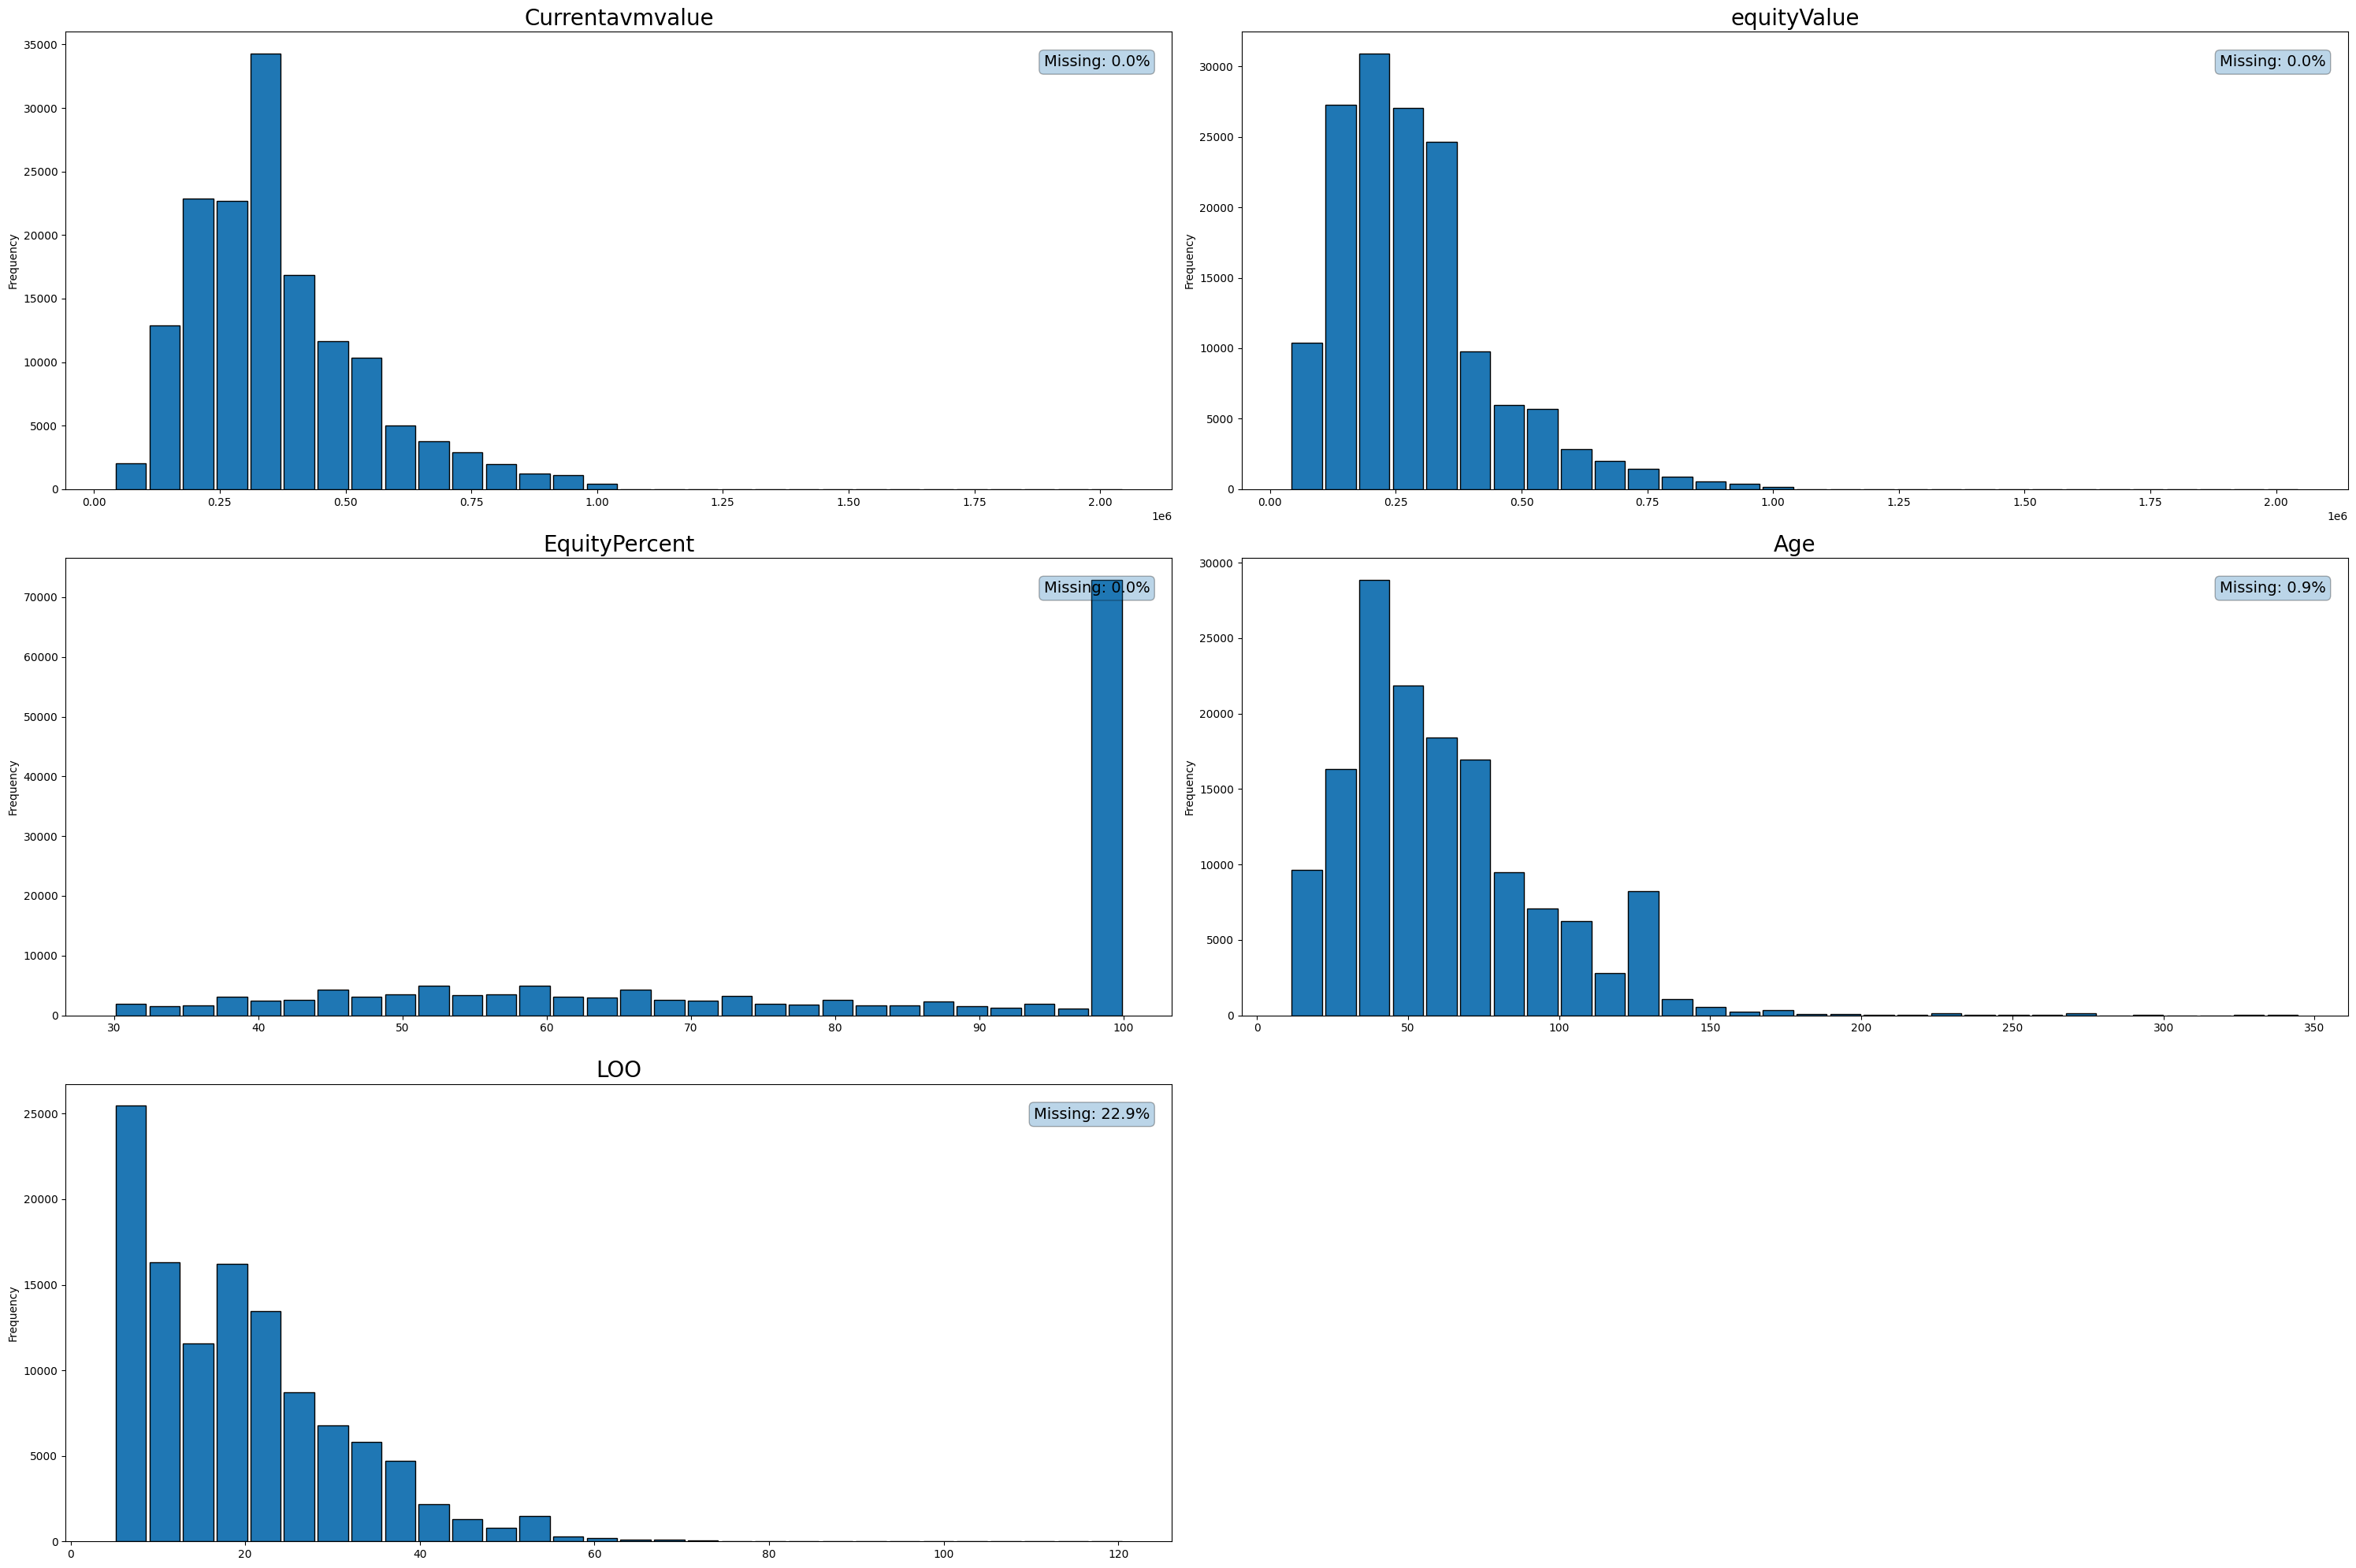

In [96]:
# make a 2 by 2 plot
plt.figure(figsize=(30, 20))
# tier1_col exclufing final owner type
col = [c for c in tier1_col if c != "FinalOwnerType"]

for i, col in enumerate(col):
    ax = plt.subplot(3, 2, i + 1)
    ax.set_title(col,fontsize=20)
    sampled_df[col].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

    missing_pct = sampled_df[col].isna().mean() * 100

    ax.text(
        0.98, 0.95,
        f"Missing: {missing_pct:.1f}%",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.3)
    )
    
    plt.tight_layout()

### Observation:

### 1. EquityPercent = 100 is a proxy for ownership psychology, not just finance.

From a behavioral standpoint, these owners are different:

- Often long LOO
- Often older properties
- Frequently absentee owners
- Emotionally detached from the property
- Much easier investor conversations

==> EquityPercent == 100, is_fully_paid? or EquityPercent_capped?

In [97]:
# How many are fully paid?
(sampled_df['is_fully_paid']).mean()

0.481176792154719

In [98]:
# Relationship with LOO
sampled_df.groupby(sampled_df['is_fully_paid'])["LOO"].describe()

,count,mean,std,min,25%,50%,75%,max
is_fully_paid,,,,,,,,
0,67382.0,16.928916,9.913877,4.982888,8.629706,15.583847,22.102669,80.027379
1,48225.0,22.708482,12.867009,4.988364,11.463381,21.177276,31.589322,120.596851


Text(0.3, 0.3, 'Mean: 22.7')

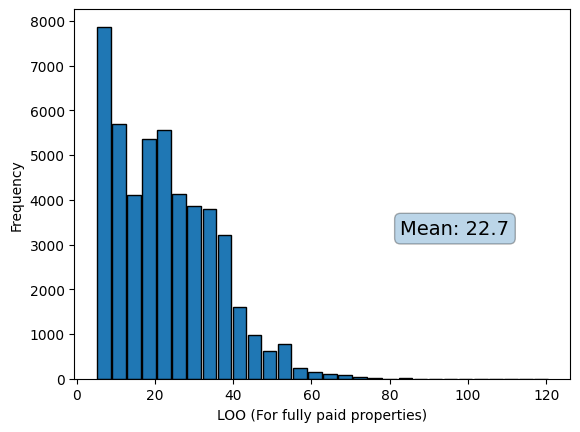

In [99]:
# plot LOO histogram for fully paid

sampled_df[sampled_df['is_fully_paid']==1]["LOO"].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

# set labels
plt.xlabel("LOO (For fully paid properties)")
plt.ylabel("Frequency")

meanLoo = round(sampled_df[sampled_df['is_fully_paid']==1]["LOO"].mean(),1)
# print the mean value
#plt.text(100, 5000, f'mean LOO:{meanLoo}')
plt.text(
        0.3, 0.3,
        f"Mean: {meanLoo:.1f}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))

In [100]:
sampled_df.head(5)

,Currentavmvalue,equityValue,EquityPercent,FinalOwnerType,owneroccupied,building_condition,multi_owner,Lien,LOO,Beds,FullBaths,HalfBaths,Sqft,Age,LOO_missing,Age_missing,is_AO,AVM_bin,is_fully_paid,Currentavmvalue_log
5067265,99000.0,99000,100,AO,0.0,NaN,1.0,NaN,34.116359,NaN,1.0,NaN,744.0,77.0,0,0,1,"(39999.999, 174000.0]",1,11.502885
2097214,172000.0,172000,100,OO,NaN,NaN,NaN,NaN,50.773443,NaN,NaN,NaN,NaN,82.0,0,0,0,"(39999.999, 174000.0]",1,12.055256
2819727,132000.0,132000,100,AO,NaN,NaN,NaN,NaN,6.253251,NaN,NaN,NaN,NaN,94.0,0,0,1,"(39999.999, 174000.0]",1,11.790565
4411295,80000.0,80000,100,AO,0.0,NaN,1.0,NaN,7.928816,NaN,1.0,NaN,960.0,71.0,0,0,1,"(39999.999, 174000.0]",1,11.289794
2109695,147000.0,147000,100,AO,NaN,NaN,NaN,NaN,43.022587,NaN,NaN,NaN,NaN,100.0,0,0,1,"(39999.999, 174000.0]",1,11.898195


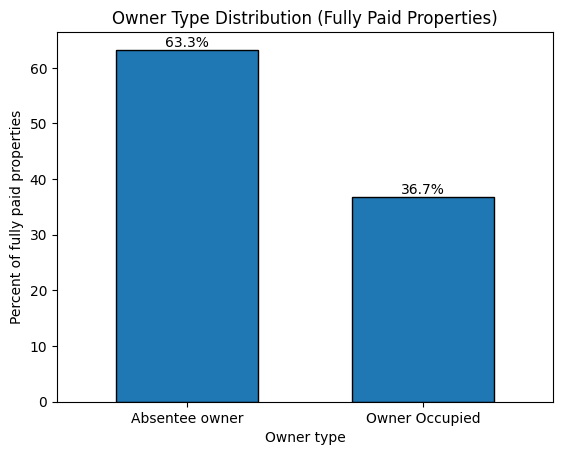

In [101]:
# plot AO histograms for fully paid

ownership_pct = sampled_df[sampled_df["is_fully_paid"] == 1]["is_AO"].value_counts(normalize=True) * 100


ax = ownership_pct.rename({1: "Absentee owner", 0: "Owner Occupied"}).plot.bar(
    edgecolor="black",
    width=0.6
)

ax.set_ylabel("Percent of fully paid properties")
ax.set_xlabel("Owner type")
ax.set_title("Owner Type Distribution (Fully Paid Properties)")

# annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom"
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()


==> Conclusion: 
- Fully paid ownership and absentee ownership are correlated, but not redundan
- Baseline rate of AO is 52%
- Being fully paid increases the likelihood of being absentee
- is_AO is a good secondary explanatory variable
    - If you had let is_AO into the distance metric --> Clusters would lean heavily toward AO/OO separation

In investor terms, fully paid owners are:
- More likely to be absentee (63.3%)
- More likely to sell directly
- Less constrained by lenders
- But one in three fully paid owners still live in the home (36.7%)

### Missing LOO is not “unknown” — it’s a proxy state

In [102]:
df_missing_loo = sampled_df[sampled_df["LOO_missing"]==1]
df_non_missing_loo = sampled_df[sampled_df["LOO_missing"]==0]

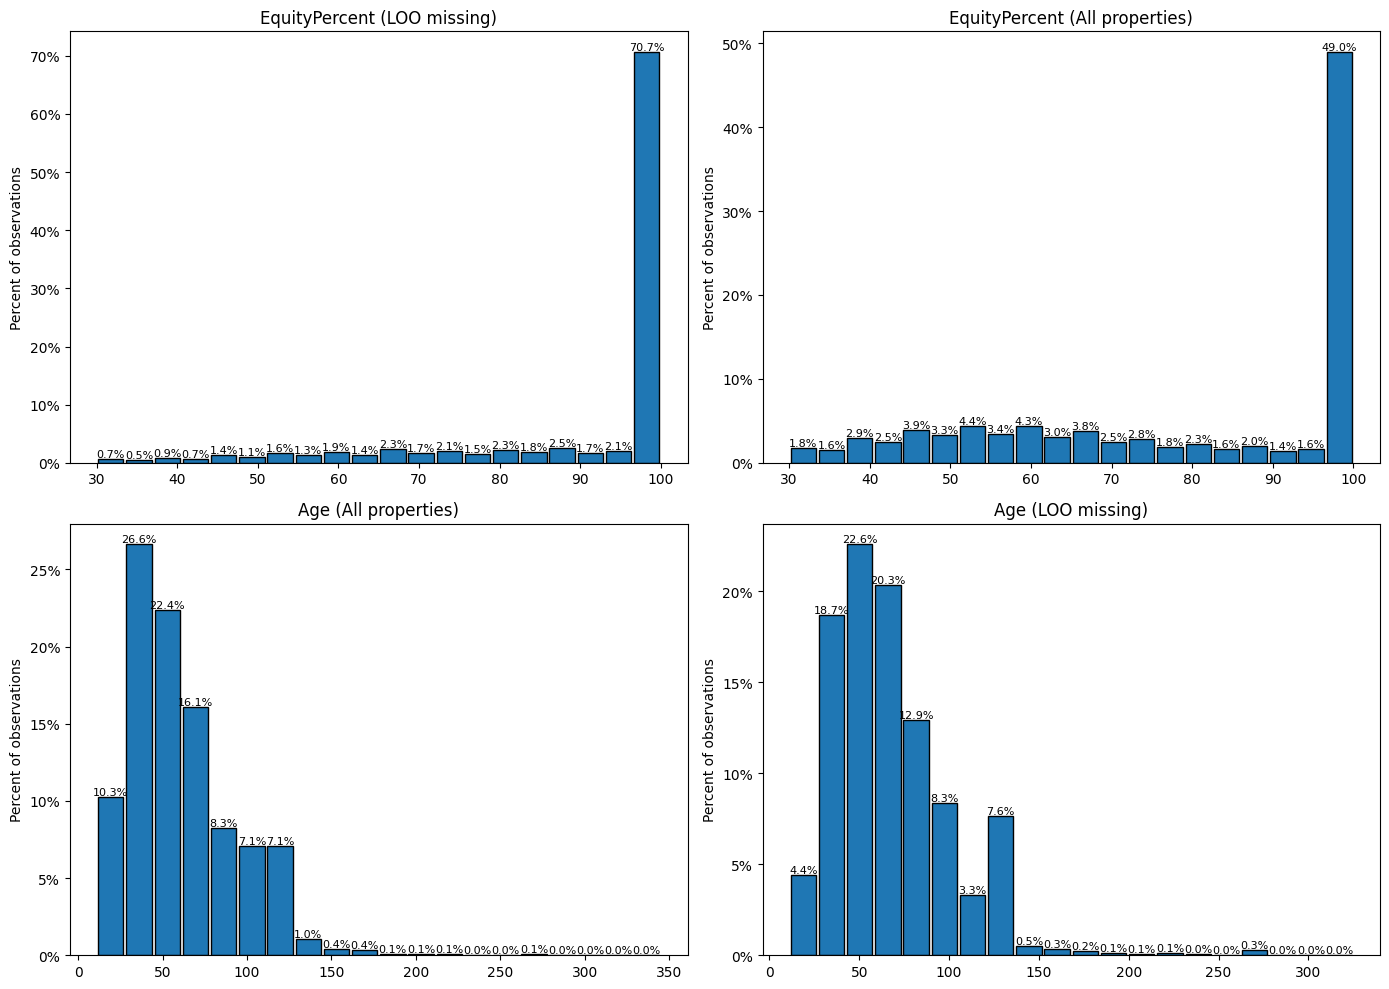

In [103]:
def percent_hist(ax, data, bins, xlabel, title):
    weights = np.ones(len(data)) / len(data) * 100

    ax.hist(
        data,
        bins=bins,
        weights=weights,
        edgecolor="black",
        rwidth=0.9
    )

    #ax.set_xlabel(xlabel)
    ax.set_ylabel("Percent of observations")
    ax.set_title(title)
    ax.yaxis.set_major_formatter(lambda y, _: f"{y:.0f}%")

    # annotate bars
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            ax.annotate(
                f"{height:.1f}%",
                (patch.get_x() + patch.get_width() / 2, height),
                ha="center",
                va="bottom",
                fontsize=8
            )

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Row 1: EquityPercent ---
percent_hist(
    ax=axes[0, 0],
    data=df_missing_loo["EquityPercent"],
    bins=20,
    xlabel="EquityPercent",
    title="EquityPercent (LOO missing)"
)

percent_hist(
    ax=axes[0, 1],
    data=sampled_df["EquityPercent"],
    bins=20,
    xlabel="EquityPercent",
    title="EquityPercent (All properties)"
)

# --- Row 2: Age ---
percent_hist(
    ax=axes[1, 0],
    data=sampled_df["Age"].dropna(),
    bins=20,
    xlabel="Age",
    title="Age (All properties)"
)

percent_hist(
    ax=axes[1, 1],
    data=df_missing_loo["Age"].dropna(),
    bins=20,
    xlabel="Age",
    title="Age (LOO missing)"
)

plt.tight_layout()
plt.show()


==> conclusion:
- LOO has two meanings depending on whether it exists.
    - Majority of missing LOO are fully paied properties ~ 71%
- Age distribution does not matter in LOO (Missing LOO is not about the house being older)


<Axes: ylabel='Frequency'>

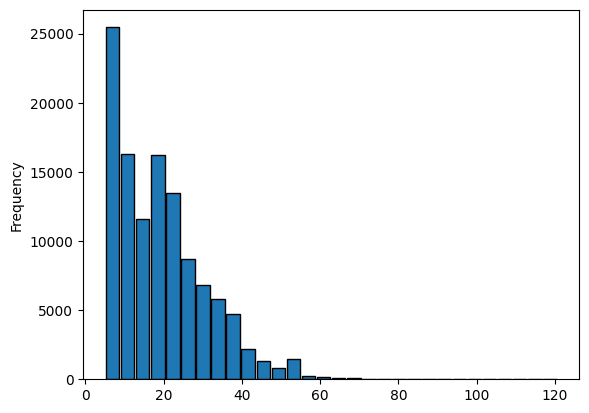

In [104]:
sampled_df[sampled_df['LOO'].notna()]['LOO'].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

In [105]:
sampled_df['Currentavmvalue'].describe()

count    1.500010e+05
mean     3.619314e+05
std      1.709245e+05
min      4.000000e+04
25%      2.394180e+05
50%      3.300000e+05
75%      4.460000e+05
max      2.046517e+06
Name: Currentavmvalue, dtype: float64

## Assembling a model of ownership behavior

In [106]:
sampled_df['Currentavmvalue_log'].describe()

count    150001.000000
mean         12.690348
std           0.475768
min          10.596660
25%          12.385970
50%          12.706851
75%          13.008076
max          14.531650
Name: Currentavmvalue_log, dtype: float64